<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S10/EVA4_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
import torch
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import sys
import torch.nn as nn
import os

##Mount Google Drive to get files

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
!rm -rf '/content/drive/My Drive/colab_notebooks/S10/__pycache__'
!ls -lrt '/content/drive/My Drive/colab_notebooks/S10/'

total 62
-rw------- 1 root root  1332 May 20 21:04 testing.py
-rw------- 1 root root  1644 May 30 06:06 train_test_loader.py
-rw------- 1 root root  4085 May 30 06:11 resnet18.py
-rw------- 1 root root 24582 Jun  6 17:30 lrfinder.py
-rw------- 1 root root  1117 Jun  6 18:20 get_images.py
drwx------ 2 root root  4096 Jun  6 18:21 data
-rw------- 1 root root  1731 Jun  6 18:55 training.py
-rw------- 1 root root   882 Jun  6 19:22 visualise_loss_acc.py
-rw------- 1 root root  6806 Jun  6 19:46 gradcam.py
-rw------- 1 root root   771 Jun  7 00:20 albumentation_transforms.py
-rw------- 1 root root 12977 Jun  7 00:21 EVA4_S10.ipynb


##Add Google Drive path to system path

In [4]:
os.chdir('./drive/My Drive/colab_notebooks/S10/')

!ls

albumentation_transforms.py  get_images.py  resnet18.py  train_test_loader.py
data			     gradcam.py     testing.py	 visualise_loss_acc.py
EVA4_S10.ipynb		     lrfinder.py    training.py


##Import python files

In [5]:
import train_test_loader as ttl
import resnet18 as bm
import training as trn
import testing as tst
from lrfinder import LRFinder
import visualise_loss_acc as vis
import gradcam as gc
import get_images as gc_img

  pip install torch-lr-finder -v --global-option="amp"


##Main Function

In [0]:
def main(classes,dropout,lrate,momentum,batch_size,num_imgs):

  train_loader, test_loader,test_transform = ttl.get_train_test(classes)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)

  model = bm.ResNet18(dropout=dropout).to(device)
  summary(model, input_size=(3, 32, 32))

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lrate, momentum=momentum)

  ##LR FINDER##
  lr_finder = LRFinder(model, optimizer, criterion, device=device)
  lr_finder.range_test(train_loader,start_lr=1e-6, end_lr=1.4, num_iter=500, step_mode='exp')
  lr_finder.plot(log_lr=True)
  lr_finder.reset()

  best_loss = lr_finder.best_loss
  best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
  ##LR FINDER ENDS##

  ##RESET LR##
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=momentum)
  scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)
  ##RESET LR ENDS##
  
  EPOCHS=50
 
  test_loss=[]
  test_accuracy=[]
  train_loss=[]
  train_accuracy=[]
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch + 1)
      train_losses,train_acc=trn.train(model, device, train_loader, optimizer,EPOCHS,criterion,l1=1e-6,l2=1e-3)
      test_losses,test_acc=tst.test(model, device, test_loader,criterion)
      scheduler.step(test_losses[-1])

      test_loss.append(test_losses)
      test_accuracy.append(test_acc)

      train_loss.append(train_losses)
      train_accuracy.append(train_acc)
  
  vis.plot_acc_loss(test_loss,test_accuracy,train_loss,train_accuracy)
  
  ##gradcam##

  misclass=gc_img.get_images(model,device, test_loader,batch_size=batch_size,num_imgs=num_imgs)
  target_layers = ["layer1","layer2","layer3","layer4"]
  viz_cam = gc.VisualizeCam(model,classes, target_layers)

  num_img = len(misclass)

  incorrect_pred_imgs = []
  inc_image_for_gradcam = []
  for i in range(num_img):
    incorrect_pred_imgs.append(torch.as_tensor(misclass[i][0]))
    inc_image_for_gradcam.append(misclass[i])

  print('\n--GRADCAM FOR MISCLASSIFIED IMAGES--')
  # print(len(incorrect_pred_imgs))
  # print(len(inc_image_for_gradcam))
  viz_cam(torch.stack(incorrect_pred_imgs), inc_image_for_gradcam, target_layers, metric="incorrect")

##Calling Main

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
 


Learning rate search finished. See the graph with {finder_name}.plot()


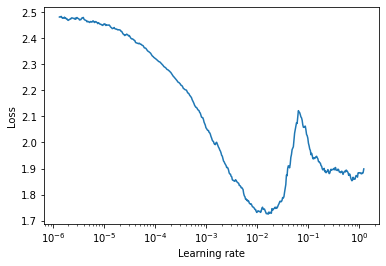

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.704535961151123 Batch_id=390 Accuracy=44.41: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6060/10000 (60.60%)

EPOCH: 2


Loss=1.3762763738632202 Batch_id=390 Accuracy=62.53: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6986/10000 (69.86%)

EPOCH: 3


Loss=1.324338436126709 Batch_id=390 Accuracy=70.98: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7264/10000 (72.64%)

EPOCH: 4


Loss=1.1553819179534912 Batch_id=390 Accuracy=75.20: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7631/10000 (76.31%)

EPOCH: 5


Loss=1.149510145187378 Batch_id=390 Accuracy=78.32: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7853/10000 (78.53%)

EPOCH: 6


Loss=1.0511014461517334 Batch_id=390 Accuracy=80.75: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8082/10000 (80.82%)

EPOCH: 7


Loss=1.1094003915786743 Batch_id=390 Accuracy=82.36: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7918/10000 (79.18%)

EPOCH: 8


Loss=1.118794560432434 Batch_id=390 Accuracy=83.82: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8447/10000 (84.47%)

EPOCH: 9


Loss=1.103636622428894 Batch_id=390 Accuracy=84.68: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8499/10000 (84.99%)

EPOCH: 10


Loss=0.9899028539657593 Batch_id=390 Accuracy=86.09: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8494/10000 (84.94%)

EPOCH: 11


Loss=0.9723855257034302 Batch_id=390 Accuracy=86.80: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8537/10000 (85.37%)

EPOCH: 12


Loss=0.9762237071990967 Batch_id=390 Accuracy=87.55: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8367/10000 (83.67%)

EPOCH: 13


Loss=0.8636617660522461 Batch_id=390 Accuracy=88.35: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8612/10000 (86.12%)

EPOCH: 14


Loss=0.8305374383926392 Batch_id=390 Accuracy=89.26: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8647/10000 (86.47%)

EPOCH: 15


Loss=0.859595537185669 Batch_id=390 Accuracy=89.45: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8652/10000 (86.52%)

EPOCH: 16


Loss=0.7824404835700989 Batch_id=390 Accuracy=90.26: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8744/10000 (87.44%)

EPOCH: 17


Loss=0.9066842794418335 Batch_id=390 Accuracy=90.41: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8819/10000 (88.19%)

EPOCH: 18


Loss=0.8321828842163086 Batch_id=390 Accuracy=91.15: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8661/10000 (86.61%)

EPOCH: 19


Loss=0.8452961444854736 Batch_id=390 Accuracy=91.26: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8594/10000 (85.94%)

EPOCH: 20


Loss=0.7464208006858826 Batch_id=390 Accuracy=91.86: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8750/10000 (87.50%)

EPOCH: 21


Loss=0.8804195523262024 Batch_id=390 Accuracy=92.12: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8784/10000 (87.84%)

Epoch    21: reducing learning rate of group 0 to 1.6307e-03.
EPOCH: 22


Loss=0.7406281232833862 Batch_id=390 Accuracy=94.98: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9082/10000 (90.82%)

EPOCH: 23


Loss=0.65639328956604 Batch_id=390 Accuracy=95.95: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9118/10000 (91.18%)

EPOCH: 24


Loss=0.6465333700180054 Batch_id=390 Accuracy=96.27: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9131/10000 (91.31%)

EPOCH: 25


Loss=0.6896682977676392 Batch_id=390 Accuracy=96.46: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9124/10000 (91.24%)

EPOCH: 26


Loss=0.6406421661376953 Batch_id=390 Accuracy=96.54: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9149/10000 (91.49%)

EPOCH: 27


Loss=0.6718276143074036 Batch_id=390 Accuracy=96.79: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9130/10000 (91.30%)

EPOCH: 28


Loss=0.6531244516372681 Batch_id=390 Accuracy=96.99: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9128/10000 (91.28%)

EPOCH: 29


Loss=0.7012872695922852 Batch_id=390 Accuracy=96.94: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9138/10000 (91.38%)

EPOCH: 30


Loss=0.7344555854797363 Batch_id=390 Accuracy=97.19: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9130/10000 (91.30%)

Epoch    30: reducing learning rate of group 0 to 1.6307e-04.
EPOCH: 31


Loss=0.5961699485778809 Batch_id=390 Accuracy=97.29: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9141/10000 (91.41%)

EPOCH: 32


Loss=0.6092759370803833 Batch_id=390 Accuracy=97.18: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9139/10000 (91.39%)

EPOCH: 33


Loss=0.6800402402877808 Batch_id=390 Accuracy=97.33: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9150/10000 (91.50%)

EPOCH: 34


Loss=0.7474662065505981 Batch_id=390 Accuracy=97.44: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9135/10000 (91.35%)

Epoch    34: reducing learning rate of group 0 to 1.6307e-05.
EPOCH: 35


Loss=0.6898901462554932 Batch_id=390 Accuracy=97.35: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9147/10000 (91.47%)

EPOCH: 36


Loss=0.7351137399673462 Batch_id=390 Accuracy=97.43: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9156/10000 (91.56%)

EPOCH: 37


Loss=0.6253323554992676 Batch_id=390 Accuracy=97.36: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9148/10000 (91.48%)

EPOCH: 38


Loss=0.6832505464553833 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)

Epoch    38: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 39


Loss=0.6698207855224609 Batch_id=390 Accuracy=97.41: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9153/10000 (91.53%)

EPOCH: 40


Loss=0.7287243604660034 Batch_id=390 Accuracy=97.39: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9150/10000 (91.50%)

EPOCH: 41


Loss=0.6161189079284668 Batch_id=390 Accuracy=97.51: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9142/10000 (91.42%)

EPOCH: 42


Loss=0.6975113153457642 Batch_id=390 Accuracy=97.36: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9152/10000 (91.52%)

EPOCH: 43


Loss=0.6245870590209961 Batch_id=390 Accuracy=97.48: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)

EPOCH: 44


Loss=0.6371402144432068 Batch_id=390 Accuracy=97.52: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9144/10000 (91.44%)

EPOCH: 45


Loss=0.6597816348075867 Batch_id=390 Accuracy=97.46: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9147/10000 (91.47%)

EPOCH: 46


Loss=0.6514477729797363 Batch_id=390 Accuracy=97.41: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9150/10000 (91.50%)

EPOCH: 47


Loss=0.6928551197052002 Batch_id=390 Accuracy=97.27: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)

EPOCH: 48


Loss=0.5957358479499817 Batch_id=390 Accuracy=97.46: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9149/10000 (91.49%)

EPOCH: 49


Loss=0.6571047306060791 Batch_id=390 Accuracy=97.46: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9154/10000 (91.54%)

EPOCH: 50


Loss=0.6808693408966064 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 0.0023, Accuracy: 9152/10000 (91.52%)




--GRADCAM FOR MISCLASSIFIED IMAGES--


/content/drive/My Drive/colab_notebooks/S10/gradcam.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw={'xticks': [], 'yticks': []})


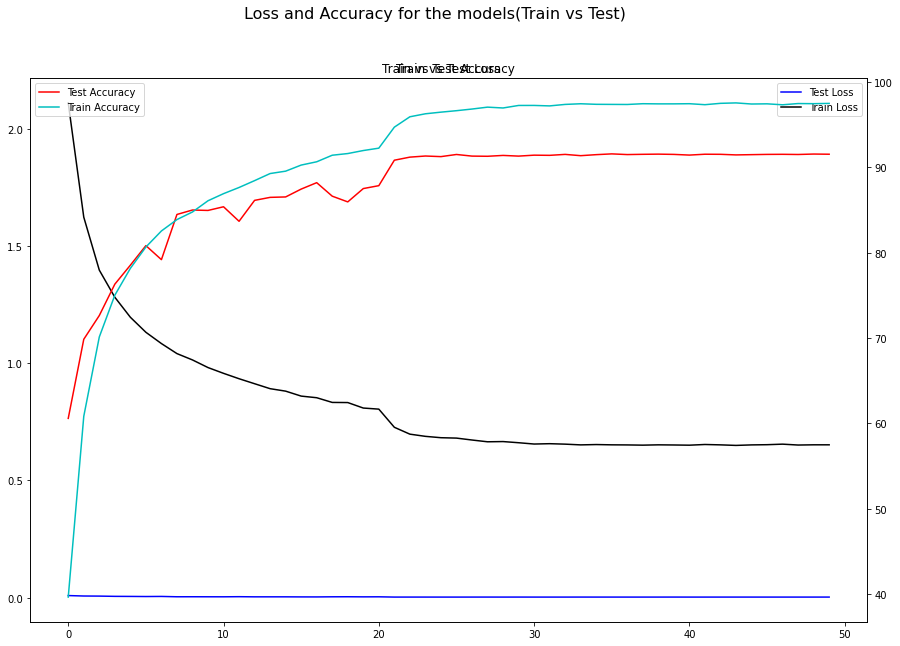

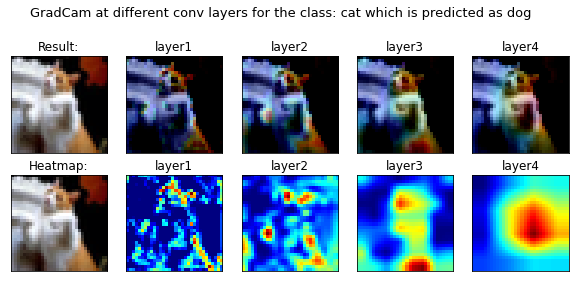

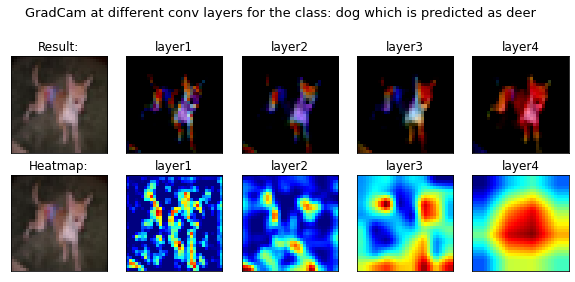

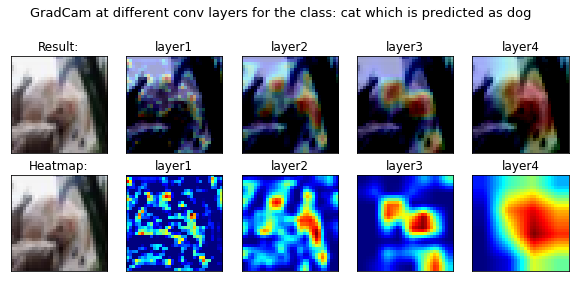

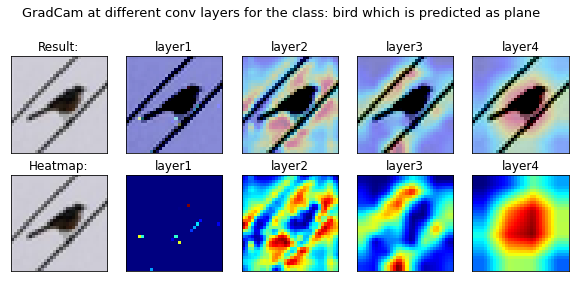

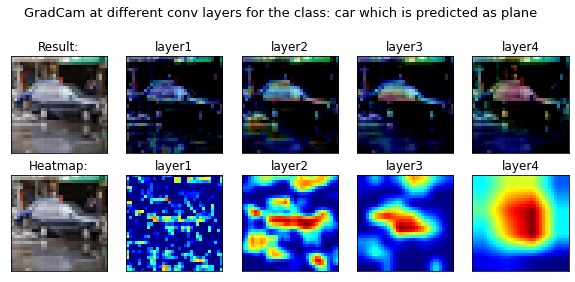

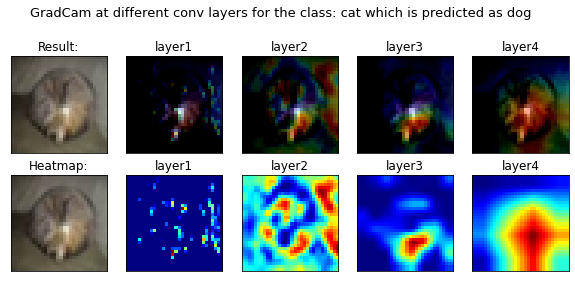

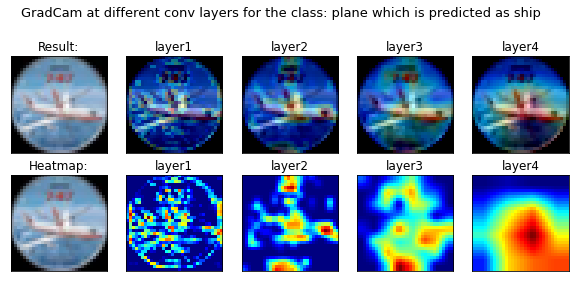

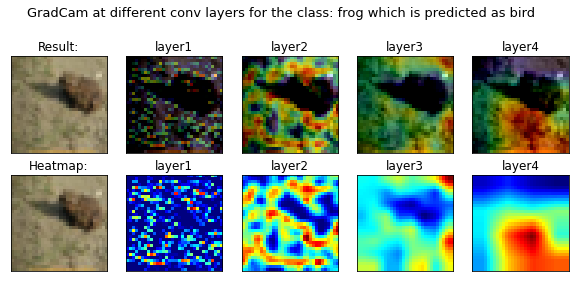

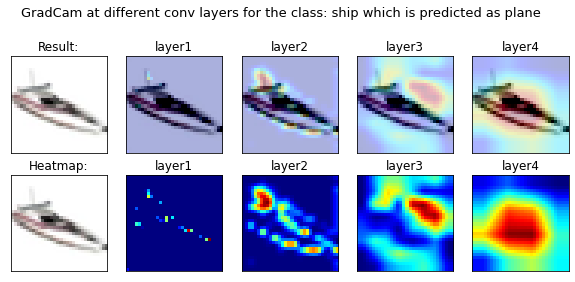

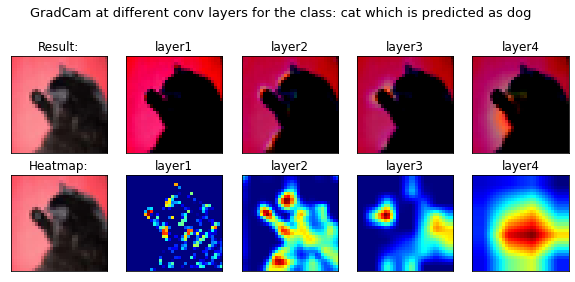

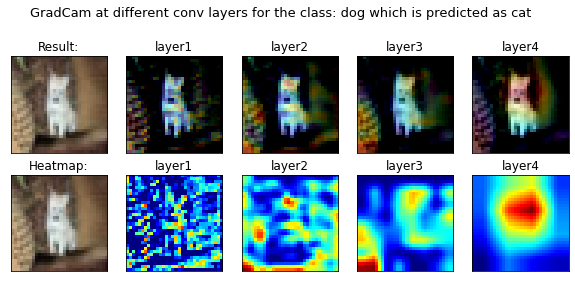

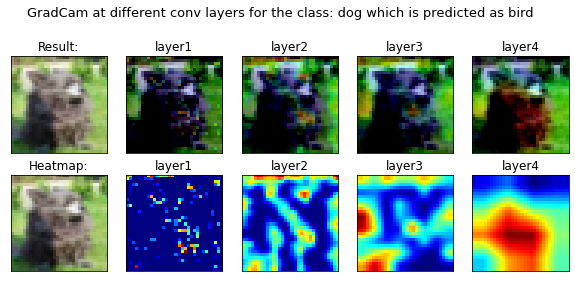

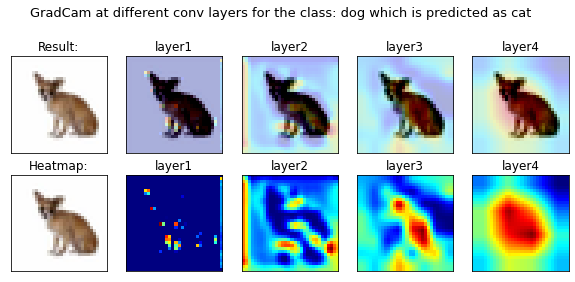

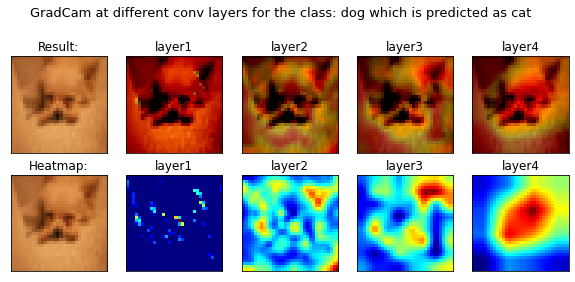

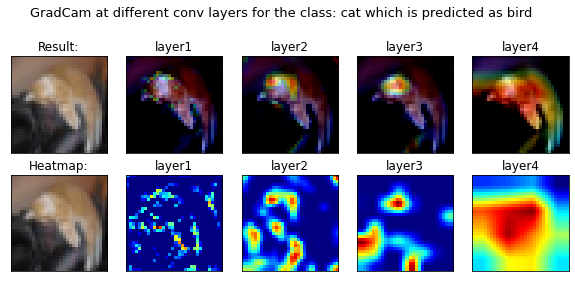

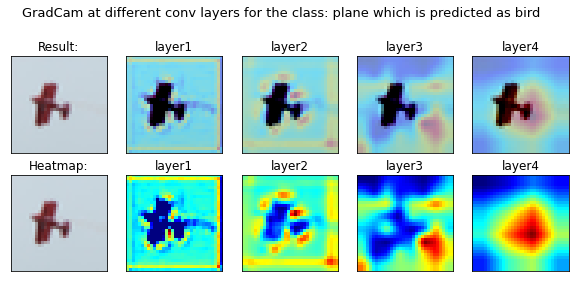

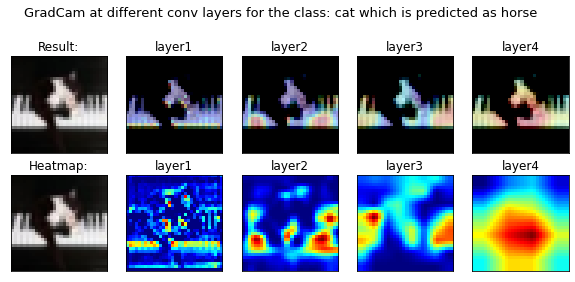

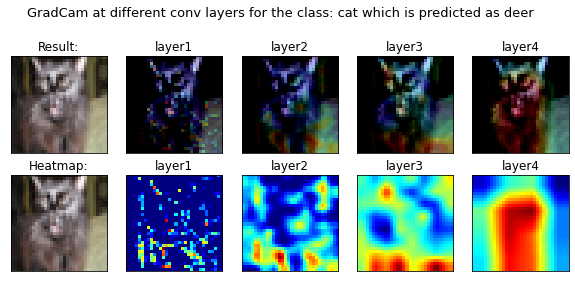

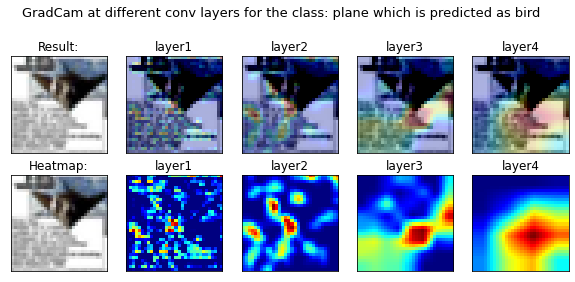

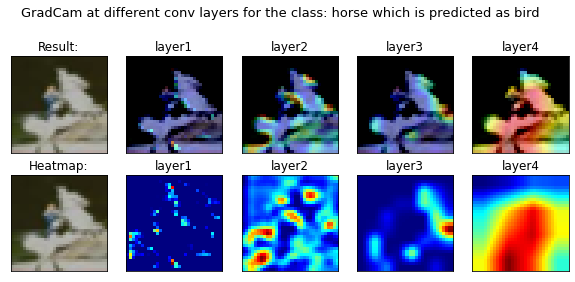

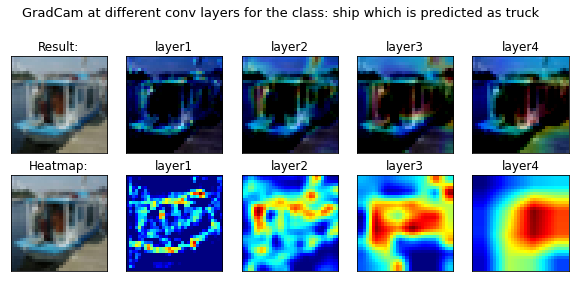

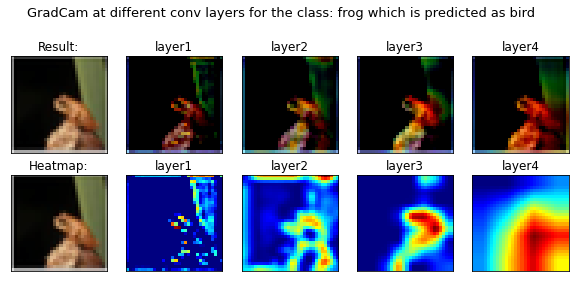

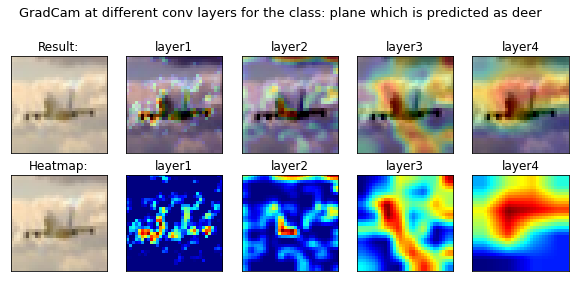

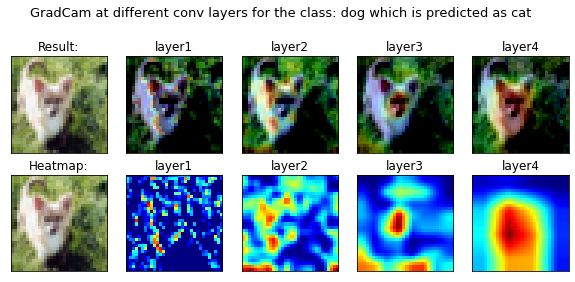

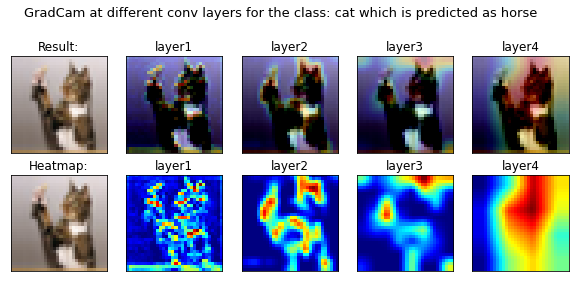

In [7]:
if __name__ == '__main__':
  from tqdm import tqdm
  if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')
  
  dropout=0.15
  lrate=0.0001
  momentum=0.9
  batch_size=128
  num_imgs=25
  
  main(classes,dropout,lrate,momentum,batch_size,num_imgs)